In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from math import sqrt, log
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score
from sklearn import preprocessing

# Gives warning bug see: https://github.com/pandas-dev/pandas/issues/39554
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Whether to read realistic data file or nooutliers data file. 
df = pd.read_csv('realistic_data.csv')
#df = pd.read_csv('nooutliers_data.csv')

# Whether to plot everything or not
PLOT_EDA2 = True

## Pre-process cleaned data

In [2]:
# Create columns for variables that have a value
for var in df["variable"].unique():
    df['%s'%var] = np.where(df['variable'] == var, df['value'], np.NaN)

# Split the date-time in seperate columns, transform to a datetime format
df[['date', 'time']] = df['time'].str.split(' ', 1, expand=True)
df['time'] = pd.to_datetime(df['date'] + ' ' + df['time'], format='%Y-%m-%d %H:%M:%S.%f')

# Print example
df.head()

,Unnamed: 0,index,Unnamed: 0.1,id,time,variable,value,mood,circumplex.arousal,circumplex.valence,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,date
0,0,0,1,1,2014-02-26 13:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
1,1,1,2,1,2014-02-26 15:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
2,2,2,3,1,2014-02-26 18:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
3,3,3,4,1,2014-02-26 21:00:00,mood,7.0,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-26
4,4,4,5,1,2014-02-27 09:00:00,mood,6.0,6.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-02-27


## Group by day, merge all users in one dataset

In [3]:
# Pick one sample user

def create_merged_dataset(df):
    frames = []
    unique_users = df['id'].unique()
    for uu in unique_users:
        df1 = df[df['id'] == uu]
        df_avg = pd.DataFrame()

        # Average over the day
        take_mean = set(("mood", "activity", "circumplex.arousal", "circumplex.valence"))

        # Total time everyday
        take_sum = set(("screen", "appCat.builtin","appCat.communication","appCat.entertainment", 
                        "appCat.finance", "appCat.game", "appCat.office", "appCat.other", "appCat.social",  
                        "appCat.travel", "appCat.unknown", "appCat.utilities", "appCat.weather"))

        # Amount of calls or texts a day
        take_count = set(("call", "sms"))

        for var in df["variable"].unique():
            df2 = df1[df1[var].notna()]
            if var in take_mean:
                df_mean = df2.groupby('date').mean()
                df_avg[var] = df_mean[var]
            if var in take_sum:
                df_sum = df2.groupby('date').mean()
                df_avg[var] = df_sum[var]
            if var in take_count:
                df_count = df2.groupby('date').count()
                df_avg[var] = df_count[var]
        
        df_avg["id"] = uu
        
        # Provide benchmark mood by taking mood from day before
        df_avg["Benchmark_mood_pred"] = df_avg.mood.shift(1)
        
        frames.append(df_avg)
        

    df_merged = pd.concat(frames)
    col = df_merged.pop("id")
    df_merged.insert(0, col.name, col)
    return df_merged

df_merged = create_merged_dataset(df)
#print('Dataset with all id, not yet aggregated the values for different time periods')
dfa1401 = df_merged[df_merged['id']=='AS14.01']
print('length of merged dataset:', len(df_merged))
print(df_merged.isna().sum())
df_merged.head()

length of merged dataset: 1268
id                         0
mood                       0
circumplex.arousal         0
circumplex.valence         2
activity                 118
screen                   100
call                     528
sms                      840
appCat.builtin           111
appCat.communication     121
appCat.entertainment     445
appCat.finance          1062
appCat.game             1079
appCat.office            998
appCat.other             165
appCat.social            306
appCat.travel            850
appCat.unknown          1013
appCat.utilities         844
appCat.weather          1157
Benchmark_mood_pred       27
dtype: int64


,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,-0.25,0.750000,NaN,NaN,1.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-27,1,6.333333,0.00,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.250000
2014-03-21,1,6.200000,0.20,0.200000,0.134050,81.254545,6.0,NaN,5.962021,47.019804,...,3.8294,NaN,57.402,29.968875,64.902404,39.064,NaN,11.32795,NaN,6.333333
2014-03-22,1,6.400000,0.60,0.500000,0.236880,35.787491,3.0,1.0,4.530716,36.687838,...,6.5255,NaN,NaN,14.020429,25.252900,37.305,NaN,39.20700,NaN,6.200000
2014-03-23,1,6.800000,0.20,0.800000,0.142741,56.007602,NaN,NaN,5.342474,45.717667,...,11.4110,NaN,NaN,12.137167,47.533333,NaN,NaN,30.08600,30.386,6.400000


## Account for missing values, normalized and sqrt transform data

In [4]:
# change NaN to 0
df = df_merged.replace(np.nan, 0)

# Normalize circumplex values using min-max normalization
df['circumplex.arousal'] =(df['circumplex.arousal']-df['circumplex.arousal'].min())/(df['circumplex.arousal'].max()-df['circumplex.arousal'].min())
df['circumplex.valence'] = (df['circumplex.valence']-df['circumplex.valence'].min())/(df['circumplex.valence'].max()-df['circumplex.valence'].min())

# Replace zero's for very small values - remove 2 zero's to get better view
df = df.replace(0, 0.00000001)

# Use sqrt transformation
no_mood = df.loc[:, (df.columns != 'mood') | 
                    (df.columns != 'id') | 
                    (df.columns != "Benchmark_mood_pred")].columns
print(no_mood)
no_mood = ['circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather']
#df[no_mood].transform('sqrt')
# Use sqrt sqrt transformation
df[no_mood] = np.sqrt(df[no_mood])
df[no_mood] = np.sqrt(df[no_mood])
df

Index(['id', 'mood', 'circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather',
       'Benchmark_mood_pred'],
      dtype='object')


,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,0.813288,0.885700,0.010000,0.010000,1.000000,1.189207,0.010000,0.010000,...,0.010000,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,1.000000e-08
2014-02-27,1,6.333333,0.840896,0.835453,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,0.010000,0.01,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,6.250000e+00
2014-03-21,1,6.200000,0.861174,0.817281,0.605086,3.002354,1.565085,0.010000,1.562602,2.618606,...,1.398887,0.01,2.752528,2.339740,2.838345,2.500024,0.010000,1.834585,0.010000,6.333333e+00
2014-03-22,1,6.400000,0.897901,0.856621,0.697641,2.445867,1.316074,1.000000,1.458954,2.461107,...,1.598282,0.01,0.010000,1.935042,2.241702,2.471393,0.010000,2.502309,0.010000,6.200000e+00
2014-03-23,1,6.800000,0.861174,0.891185,0.614663,2.735658,0.010000,0.010000,1.520322,2.600285,...,1.837938,0.01,0.010000,1.866506,2.625727,0.010000,0.010000,2.342023,2.347839,6.400000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,33,6.200000,0.769161,0.844112,0.335728,3.106083,1.000000,1.189207,1.438745,2.680415,...,0.010000,0.01,0.010000,2.055052,2.281373,0.010000,0.010000,1.000250,0.010000,5.400000e+00
2014-05-28,33,8.200000,0.840896,0.931796,0.566926,2.965266,1.778279,1.000000,1.537597,2.327737,...,0.010000,0.01,2.528221,2.201263,2.774436,0.010000,0.010000,1.503580,0.010000,6.200000e+00
2014-05-29,33,7.000000,0.638943,0.912168,0.641504,2.862369,1.495349,1.000000,1.529362,2.654587,...,0.010000,0.01,0.010000,1.766334,3.664780,0.984388,0.010000,1.124595,0.010000,8.200000e+00


## Perform second EDA on transformed and cleaned data

There is 2 strongly correlated values with mood:
mood                  1.000000
circumplex.valence    0.529959
Name: mood, dtype: float64
features to analyse: ['mood', 'circumplex.valence']


,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,0.949645,0.970112,0.316228,0.316228,1.000000,1.044274,0.316228,0.316228,...,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,1.000000e-08
2014-02-27,1,6.333333,0.957603,0.956050,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,...,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,6.250000e+00
2014-03-21,1,6.200000,0.963325,0.950808,0.881971,1.316332,1.118496,0.316228,1.118052,1.272089,...,1.087541,0.316228,1.288051,1.236778,1.297975,1.257436,0.316228,1.163816,0.316228,6.333333e+00
2014-03-22,1,6.400000,0.973435,0.962049,0.913920,1.250571,1.071075,1.000000,1.099032,1.252514,...,1.124381,0.316228,0.316228,1.179431,1.223614,1.253821,0.316228,1.257724,0.316228,6.200000e+00
2014-03-23,1,6.800000,0.963325,0.971610,0.885440,1.286072,0.316228,0.316228,1.110411,1.269858,...,1.164348,0.316228,0.316228,1.168846,1.272953,0.316228,0.316228,1.237080,1.237847,6.400000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,33,6.200000,0.936492,0.958517,0.761197,1.327557,1.000000,1.044274,1.095206,1.279530,...,0.316228,0.316228,0.316228,1.197308,1.228992,0.316228,0.316228,1.000062,0.316228,5.400000e+00
2014-05-28,33,8.200000,0.957603,0.982495,0.867724,1.312248,1.154782,1.000000,1.113552,1.235189,...,0.316228,0.316228,1.260967,1.218058,1.290606,0.316228,0.316228,1.107342,0.316228,6.200000e+00
2014-05-29,33,7.000000,0.894058,0.977279,0.894952,1.300713,1.105823,1.000000,1.112058,1.276437,...,0.316228,0.316228,0.316228,1.152838,1.383605,0.996074,0.316228,1.029791,0.316228,8.200000e+00


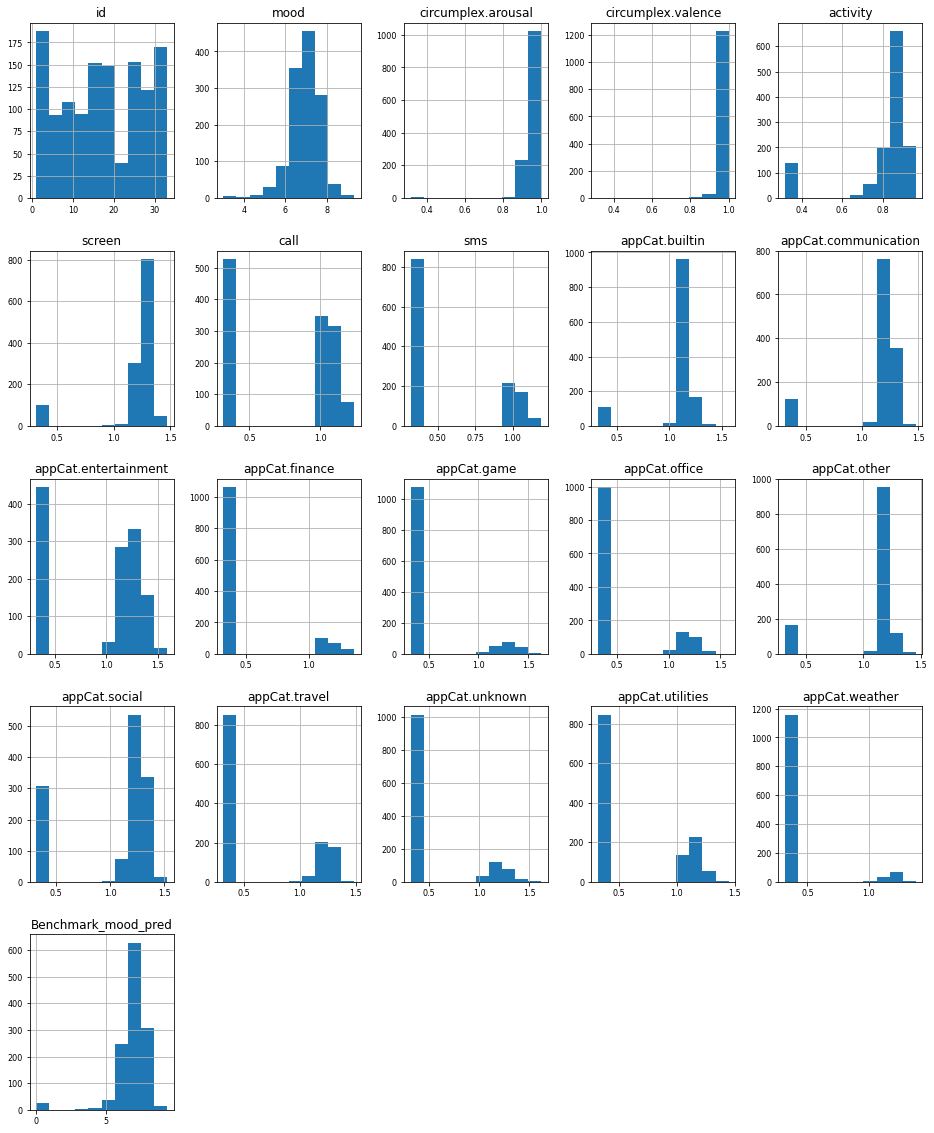

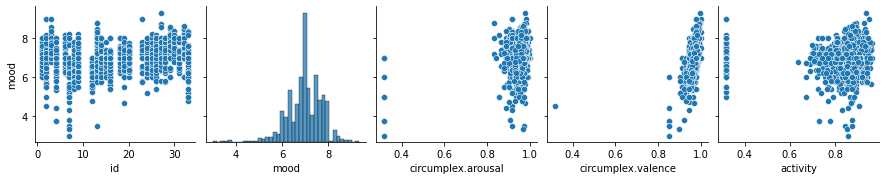

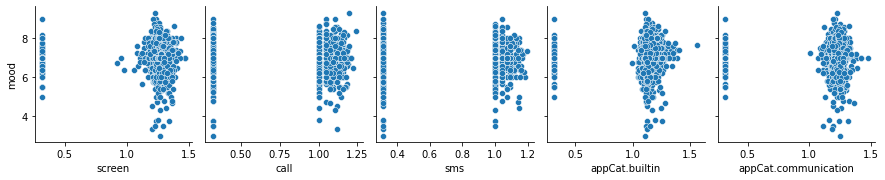

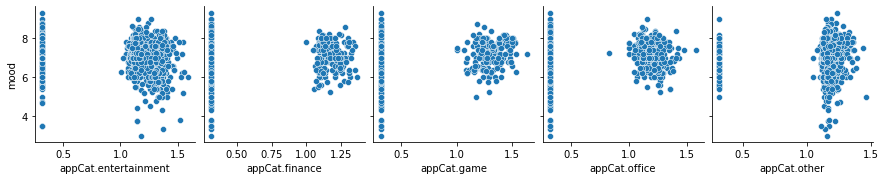

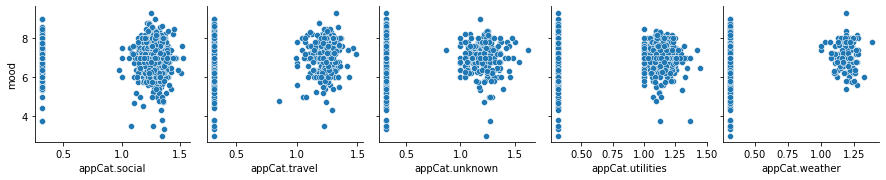

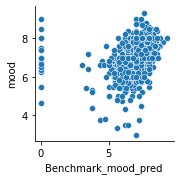

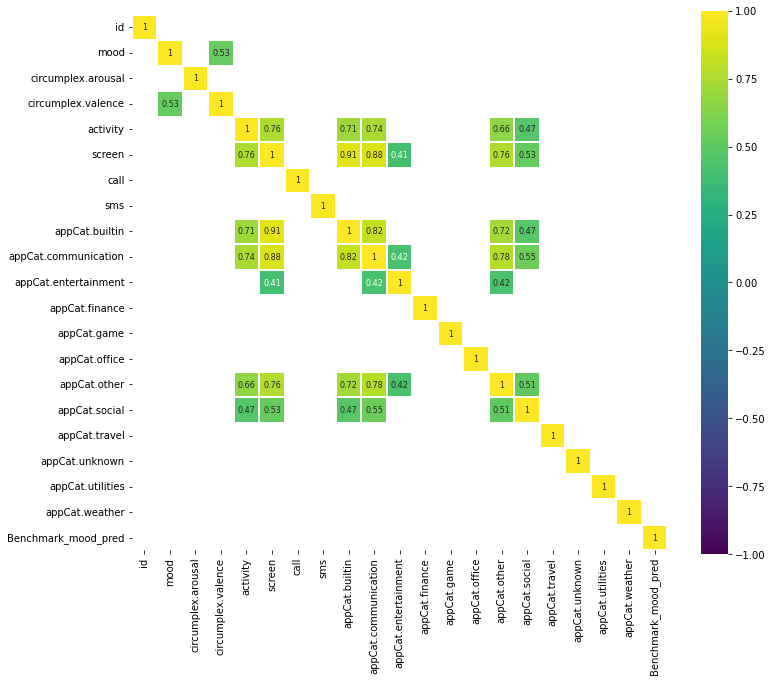

In [6]:
def print_plot_eda2(df):
    # distribution plots of all variables
    df.reset_index(inplace=True) # needs index for plot
    df.hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8);

    # only valence correlated, however nothing done with outliers
    df_avg_corr = df.corr()['mood'][1:]
    golden_features_list = df_avg_corr[abs(df_avg_corr) > 0.4].sort_values(ascending=False)
    print("There is {} strongly correlated values with mood:\n{}".format(len(golden_features_list), golden_features_list))
    
    # scatterplots of all variables against mood
    for i in range(1, len(df.columns)+1, 5):
        sns.pairplot(data=df,
                    x_vars=df.columns[i:i+5],
                    y_vars=['mood'])
        
    # call correlates 1 on 1 with  app unknown and sms 1 on 1 with app office (only first participant)
    corr = df.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr[(corr >= 0.4) | (corr <= -0.4)], 
                cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
                annot=True, annot_kws={"size": 8}, square=True);
    
    features_to_analyse = [x for x in df.columns if x in golden_features_list]
    print('features to analyse:', features_to_analyse)
    
    ''' fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

    for i, ax in enumerate(fig.axes):
        if i < len(features_to_analyse) - 1:
            sns.regplot(x=features_to_analyse[i],y='mood', data=df[features_to_analyse], ax=ax)'''
    df.set_index('date',inplace=True) # changes index back
    return

if PLOT_EDA2:
    print_plot_eda2(df)

df

In [7]:
## Evaluate attributes, check for outliers/leverage points and colinearity.

In [8]:
df


,id,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,appCat.communication,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,Benchmark_mood_pred
date,,,,,,,,,,,,,,,,,,,,,
2014-02-26,1,6.250000,0.949645,0.970112,0.316228,0.316228,1.000000,1.044274,0.316228,0.316228,...,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,1.000000e-08
2014-02-27,1,6.333333,0.957603,0.956050,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,...,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,0.316228,6.250000e+00
2014-03-21,1,6.200000,0.963325,0.950808,0.881971,1.316332,1.118496,0.316228,1.118052,1.272089,...,1.087541,0.316228,1.288051,1.236778,1.297975,1.257436,0.316228,1.163816,0.316228,6.333333e+00
2014-03-22,1,6.400000,0.973435,0.962049,0.913920,1.250571,1.071075,1.000000,1.099032,1.252514,...,1.124381,0.316228,0.316228,1.179431,1.223614,1.253821,0.316228,1.257724,0.316228,6.200000e+00
2014-03-23,1,6.800000,0.963325,0.971610,0.885440,1.286072,0.316228,0.316228,1.110411,1.269858,...,1.164348,0.316228,0.316228,1.168846,1.272953,0.316228,0.316228,1.237080,1.237847,6.400000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-05-27,33,6.200000,0.936492,0.958517,0.761197,1.327557,1.000000,1.044274,1.095206,1.279530,...,0.316228,0.316228,0.316228,1.197308,1.228992,0.316228,0.316228,1.000062,0.316228,5.400000e+00
2014-05-28,33,8.200000,0.957603,0.982495,0.867724,1.312248,1.154782,1.000000,1.113552,1.235189,...,0.316228,0.316228,1.260967,1.218058,1.290606,0.316228,0.316228,1.107342,0.316228,6.200000e+00
2014-05-29,33,7.000000,0.894058,0.977279,0.894952,1.300713,1.105823,1.000000,1.112058,1.276437,...,0.316228,0.316228,0.316228,1.152838,1.383605,0.996074,0.316228,1.029791,0.316228,8.200000e+00


## Account for timestep (not a day per row but a time period of multiple days per row)

In [9]:
## Transform data period based on delta 5 timeperiod
delta = 5

# See https://sparkbyexamples.com/pandas/pandas-rolling-mean-average-sum/

pd.options.mode.chained_assignment = None  # default='warn'

def merge_on_delta(df,delta):
    frames = []
    unique_users = df['id'].unique()
    for uu in unique_users:
        df_user = df[df['id']==uu]
        
        # Get moving average of all columns except target / benchmark column mood
        df_user['ma_mood'] = df_user['mood']
        no_mood = df_user.loc[:,(df_user.columns != 'date') |  (df_user.columns != 'mood') | 
                    (df_user.columns != 'id') | 
                    (df_user.columns != "Benchmark_mood_pred")].columns
        
        # Average over delta days
        take_mean = ["ma_mood", "activity", "circumplex.arousal", "circumplex.valence"]

        # Total time over delta days
        take_sum = ["screen", "appCat.builtin","appCat.communication","appCat.entertainment", 
                        "appCat.finance", "appCat.game", "appCat.office", "appCat.other", "appCat.social",  
                        "appCat.travel", "appCat.unknown", "appCat.utilities", "appCat.weather"]

        # Amount of calls or texts every delta days
        take_count = ["call", "sms"]
        
        
        df_user.loc[:, take_mean] = df_user[take_mean].rolling(window=delta).mean()
        df_user.loc[:, take_sum] = df_user[take_sum].rolling(window=delta).sum()
        df_user.loc[:, take_count] = df_user[take_count].rolling(window=delta).count()
        
        
        # Also make moving average excluding current column. We shift all columns 1 step down except the target mood + id numbers
        df_user.loc[:, (df_user.columns != 'date') |(df_user.columns != 'mood') | 
                    (df_user.columns != 'id') | 
                    (df_user.columns != '"Benchmark_mood_pred"')] = df_user.loc[:,(df_user.columns != 'date') | (df_user.columns != 'mood') 
                                                                                | (df_user.columns != 'id')
                                                                                | (df_user.columns != '"Benchmark_mood_pred"')].shift(1)
        
        # Rename index
        df_user.index.names = ['EndDateDelta%s'%delta]
        frames.append(df_user)
        
    df_merged = pd.concat(frames)
    col = df_merged.pop("id")
    df_merged.insert(0, col.name, col)
    
    # Drop all rows that are from period < delta
    df_merged = df_merged.dropna()
    return df_merged

# Save data for temporal model (see lower cells)
df_no_delta = df


df = merge_on_delta(df, delta)

## Calculate Benchmark performance

In [10]:
benchmark_test_mse = mean_squared_error(df['mood'], df['Benchmark_mood_pred'])
benchmark_test_mae = mean_absolute_error(df['mood'], df['Benchmark_mood_pred'])

print("Benchmark test mse = ",benchmark_test_mse," & mae = ",benchmark_test_mae," & rmse = ", sqrt(benchmark_test_mse))

Benchmark test mse =  0.5644709228204374  & mae =  0.54783759929391  & rmse =  0.7513127995851245


## Perform kNN

In [11]:
attributes = df.loc[:,  (df_user.columns != 'date') |(df.columns != 'mood') | 
                    (df.columns != 'id') | 
                    (df.columns != "Benchmark_mood_pred")].columns
print(attributes)
X = df[attributes]
y = df[['mood']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

knn_model = KNeighborsRegressor(n_neighbors=12)
knn_model.fit(X_train, y_train)

train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
test_preds = knn_model.predict(X_test)
mse_test = mean_squared_error(y_test, test_preds)

knn_mse = mean_squared_error(y_train, train_preds)
knn_mae = mean_absolute_error(y_train, train_preds)
print("kNN training mse = ",knn_mse," & mae = ",knn_mae," & rmse = ", sqrt(knn_mse))

knn_test_mse = mean_squared_error(y_test, test_preds)
knn_test_mae = mean_absolute_error(y_test, test_preds)

print("kNN test mse = ",knn_test_mse," & mae = ",knn_test_mae," & rmse = ", sqrt(knn_test_mse))

NameError: name 'df_user' is not defined

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(y_test, test_preds, c=test_preds, s=50, cmap=cmap)
ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
f.colorbar(points)
plt.show()

## Random Forest Regression

In [ ]:
attributes = df.loc[:, (df.columns != 'mood') | 
                    (df.columns != 'id') | 
                    (df.columns != "Benchmark_mood_pred")].columns
X = df[attributes]
y = df[['mood']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train.values.ravel())
train_preds = rf_model.predict(X_train)

rf_mse = mean_squared_error(y_train, train_preds)
rf_mae = mean_absolute_error(y_train, train_preds)
print("Random Forest training mse = ",rf_mse," & mae = ",rf_mae," & rmse = ", sqrt(rf_mse))

test_preds = rf_model.predict(X_test)

rf_test_mse = mean_squared_error(y_test, test_preds)
rf_test_mae = mean_absolute_error(y_test, test_preds)

print("Random Forest test mse = ",rf_test_mse," & mae = ",rf_test_mae," & rmse = ", sqrt(rf_test_mse))

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(y_test, test_preds, c=test_preds, s=50, cmap=cmap)
ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
f.colorbar(points)
plt.show()

## TO DO
- Tweak performance of random forrest algo? 
- Code the temporal model
- Maybe implement cross validation

In [ ]:
df_no_delta

## ARIMA model - run for 1 user

In [ ]:
# ARIMA example
from statsmodels.tsa.arima.model import ARIMA
from random import random

df_user1 = df_no_delta[df_no_delta['id']==1]
data1 = df_user1['mood'].values


model = ARIMA(data1, order=(1, 1, 1))
model_fit = model.fit()
# make prediction
predictions = model_fit.predict()

f, ax = plt.subplots()
x = df_user1['mood'].index

plt.plot(x, df_user1['mood'], label='actual')
plt.plot(x, predictions, label='forecast')
plt.xlabel('Time')
plt.ylabel('Mood')
ymin, ymax = ax.get_xlim()
ax.set_xticks(np.round(np.linspace(ymin, ymax, 6), 2))
plt.legend()

arima_test_mse = mean_squared_error(df_user1['mood'].values, predictions)
arima_test_mae = mean_absolute_error(df_user1['mood'].values, predictions)

print("ARIMA test mse = ",arima_test_mse," & mae = ",arima_test_mae," & rmse = ", sqrt(arima_test_mse))


## Run ARIMA for every user, then take the sum of N MSE's and divide by N

In [ ]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()

MSE_list = []
MAE_list = []
unique_users = df_no_delta['id'].unique()
for uu in unique_users:
    df_u = df_no_delta[df_no_delta['id'] == uu]
    data1 = df_u['mood'].values
    
    #p: the number of lag observations in the model; also known as the lag order.
    #d: the number of times that the raw observations are differenced; also known as the degree of differencing.
    #q: the size of the moving average window; also known as the order of the moving average.
    p = 1
    d = 1
    q = 5 
    model = ARIMA(data1, order=(p, d, q))  
    model_fit = model.fit()
    # make prediction
    predictions = model_fit.predict()
    
    # Exclude first 5 predictions as these are before the moving average window works:
    actual = df_u['mood'].iloc[5:].values
    predictions = predictions[5:]
    
    arima_test_mse = mean_squared_error(actual, predictions)
    arima_test_mae = mean_absolute_error(actual, predictions)
    MSE_list.append(arima_test_mse)
    MAE_list.append(arima_test_mae)
    
    x = df_u['mood'].index
    
    # Plot all users
    points = ax.scatter(actual, predictions, c=predictions, s=50, cmap=cmap)

total_mse = sum(MSE_list)/(len(MSE_list))
total_mae = sum(MAE_list)/(len(MAE_list))

print("ARIMA all users mse = ",total_mse," & mae = ",total_mae," & rmse = ", sqrt(total_mse))

ax.set_xlabel('Actual mood')
ax.set_ylabel('Predicted mood')
f.colorbar(points)
plt.show()